## Import lib

In [1]:
import json
from openai import OpenAI
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

In [16]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pirayan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Transcribe

In [ ]:
client = OpenAI()

audio_file= open("marry_you.mp3", "rb")
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=audio_file,
    response_format="verbose_json",
    timestamp_granularities=["word"],
)

print(transcription.words)

[TranscriptionWord(end=12.079999923706055, start=10.920000076293945, word="It's"), TranscriptionWord(end=13.239999771118164, start=12.079999923706055, word='a'), TranscriptionWord(end=13.779999732971191, start=13.239999771118164, word='beautiful'), TranscriptionWord(end=14.779999732971191, start=13.779999732971191, word='night'), TranscriptionWord(end=15.579999923706055, start=14.779999732971191, word="we're"), TranscriptionWord(end=15.579999923706055, start=15.579999923706055, word='looking'), TranscriptionWord(end=16.15999984741211, start=15.579999923706055, word='for'), TranscriptionWord(end=16.479999542236328, start=16.15999984741211, word='something'), TranscriptionWord(end=16.920000076293945, start=16.479999542236328, word='dumb'), TranscriptionWord(end=17.299999237060547, start=16.920000076293945, word='to'), TranscriptionWord(end=18.440000534057617, start=17.299999237060547, word='do'), TranscriptionWord(end=19.65999984741211, start=18.5, word='Hey'), TranscriptionWord(end=20.3

## Some EDA On the data

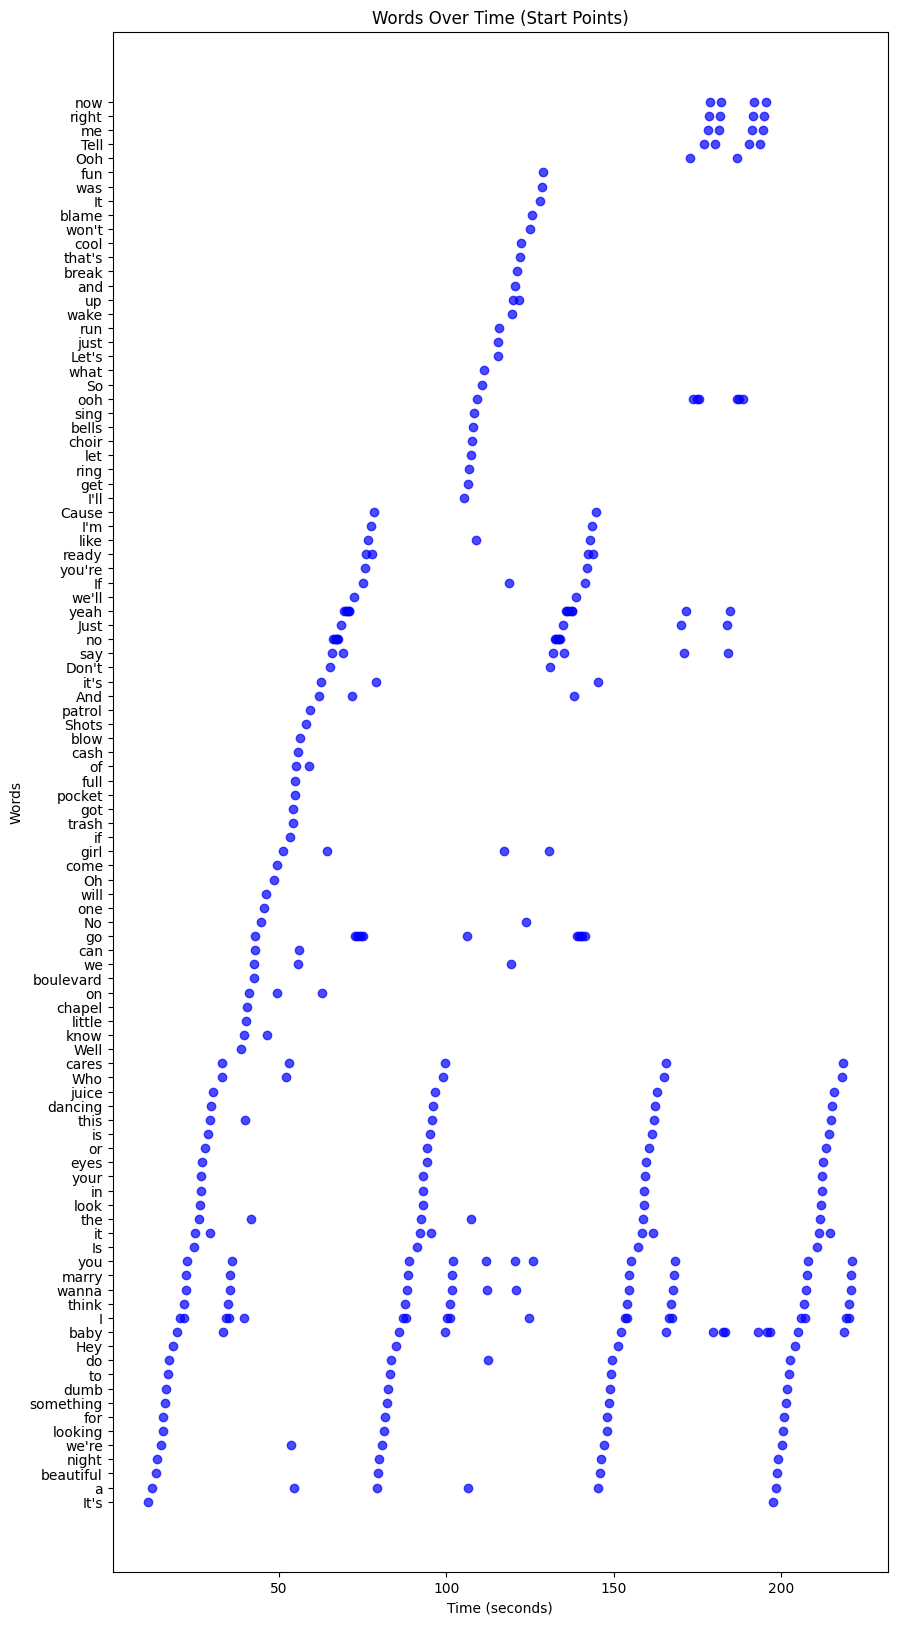

In [46]:
import matplotlib.pyplot as plt

# Extract words, start, and end times
words = [w.word for w in transcription.words]
start_times = [w.start for w in transcription.words]
end_times = [w.end for w in transcription.words]

fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(start_times, words, color="blue", alpha=0.7)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Words")
ax.set_title("Words Over Time (Start Points)")
plt.show()

## Segmenting the words

In [18]:
TIME_INTERVAL = 10
X_AXIS_INTERVAL = 30
sentiments = []
timestamps = []

In [ ]:
segments = {}
word_timestamps = []

for word_data in transcription.words:
    start_time = word_data.start
    word = word_data.word
    word_timestamps.append((start_time, word))

    segment_index = int(start_time // TIME_INTERVAL)

    if segment_index not in segments:
        segments[segment_index] = []

    segments[segment_index].append(word)

print(f"Total segments created: {len(segments)}")

Total segments created: 22


## Get the sentiment score from NLTK(VADER)

In [27]:
sia = SentimentIntensityAnalyzer()

for segment_index in sorted(segments.keys()):
    text = " ".join(segments[segment_index])
    sentiment_score = sia.polarity_scores(text)['compound']  # Get sentiment score

    timestamps.append(segment_index * TIME_INTERVAL)
    sentiments.append(sentiment_score)

In [28]:
average_sentiment = sum(sentiments) / len(sentiments)

In [37]:
# Detect "🎵" transitions
section_changes = [word_data.start for word_data in transcription.words if word_data.word == "🎵"]

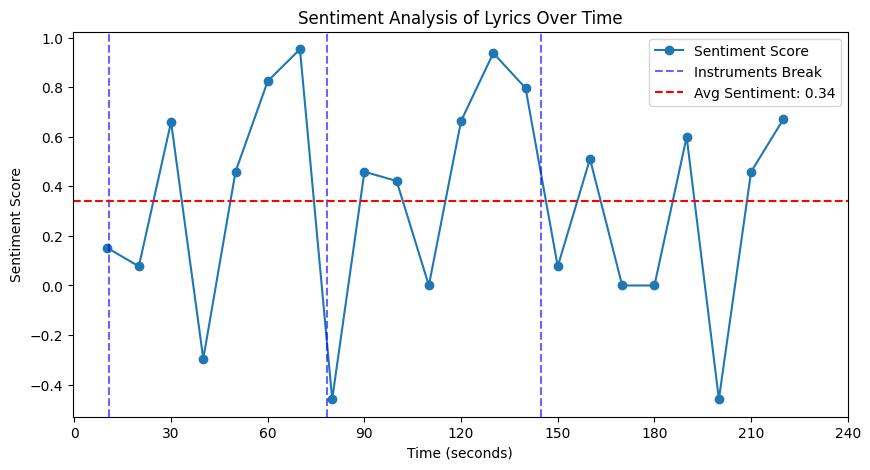

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(timestamps, sentiments, marker='o', linestyle='-', label="Sentiment Score")

for transition_time in section_changes:
    plt.axvline(transition_time, color='blue', linestyle='--', alpha=0.6, label="Instruments Break" if transition_time == section_changes[0] else "")

plt.xlabel("Time (seconds)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of Lyrics Over Time")
plt.axhline(average_sentiment, color='red', linestyle='--', label=f"Avg Sentiment: {average_sentiment:.2f}")
plt.xticks(np.arange(0, max(timestamps) + X_AXIS_INTERVAL, X_AXIS_INTERVAL))
plt.legend()
plt.show()